In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spa
import scipy.sparse.linalg as spalin
from scipy.optimize import fsolve
from tqdm import trange
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import os
import sys
sys.path.append("../dyn/")
sys.path.append("../")
sys.path.append("../phase/")
sys.path.append("../artfigs_NC/")
from dyn_ultis import *
from spatial_ultis import *
from artfigs_NC_params import *
from artfigs_NC_ultis import *

In [72]:
def generate_params_phase_wave_thres_L_1p(trial:int, trial_num:int = 21):
    trial_num = trial_num

    N_E, N_I = 40000, 10000
    alpha = 0.2
    g_bar_EE, g_bar_IE, g_bar_EI, g_bar_II = 0.575, 0.125, -1.9, -0.3632
    d_EE, d_IE, d_EI, d_II = 0.04, 0.04, 0.04, 0.16 * 0.4
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))
    g_EE, g_EI, g_IE, g_II = 0,0,0,0

    alpha_list = np.linspace(0.1,0.4,trial_num)
    alpha = alpha_list[trial]
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))
    print(conn_NEE, conn_NIE, conn_NEI, conn_NII)

    p_net = Network_Params(N_E = N_E, N_I = N_I,
        N_EE = conn_NEE, N_IE = conn_NIE, N_EI = conn_NEI, N_II = conn_NII,
        d_EE = d_EE, d_IE = d_IE, d_EI = d_EI, d_II = d_II,
        g_bar_EE = g_bar_EE, g_bar_EI = g_bar_EI, g_bar_IE = g_bar_IE, g_bar_II = g_bar_II,
        g_EE = g_EE, g_EI = g_EI, g_IE = g_IE, g_II = g_II
        )
    return p_net

112.59468070465822 28.148670176164554 112.59468070465822 72.06059565098126


c:\Users\huang-yh20\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0.9161363891756907


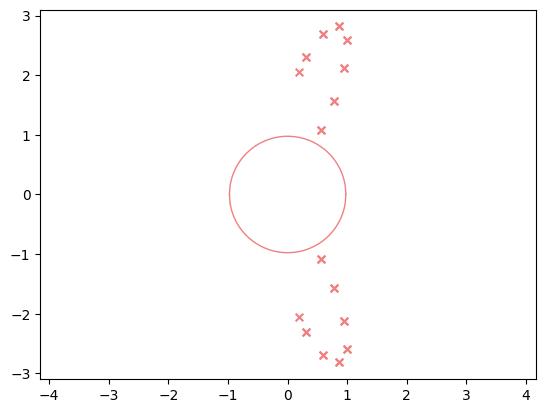

In [78]:
p_net = generate_params_phase_wave_thres_L_1p(12)
p_simul = Simul_Params(T = 2000, t_step=5, record_step=10, activation_func=['thres_linear','thres_powerlaw'], external_input="DC_noise",tau_m=20.0)
p_net_eff = calc_eff_p_net(p_net, p_simul)
temp_plot_pred(p_net_eff)
# lambda_list_pred_select, label_list_pred_select  = calc_pred_outliers(p_net_eff, dim=2)
# real_part_pred_select = np.real(lambda_list_pred_select)
# imag_part_pred_select = np.imag(lambda_list_pred_select)\
radius = calc_pred_radius(p_net_eff, dim=2)
print(radius)